In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import image_dataset_from_directory
import os
from PIL import Image
from model_params import *
from dataTransformer import *
#tf.disable_v2_behavior()
import time


%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [3]:
DATA_ROOT = "asl_alphabet_train/"
batch_size = BATCH_SIZE
img_height,img_width,img_channels = IMG_DIM

seed = 12353
validation_split = 0.2
AUTOTUNE = tf.data.AUTOTUNE

In [4]:


train_ds = image_dataset_from_directory(DATA_ROOT,shuffle=True,
                                                       validation_split=validation_split*2,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       subset="training",
                                                       seed=seed)
val_test_ds = image_dataset_from_directory(DATA_ROOT,shuffle=True,
                                                       validation_split=validation_split*2,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       subset="validation",
                                                       seed=seed)



Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Found 87000 files belonging to 29 classes.
Using 34800 files for validation.


In [5]:
val_ds = val_test_ds.skip(len(val_test_ds)//2)
test_ds = val_test_ds.take(len(val_test_ds)//2)

In [6]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


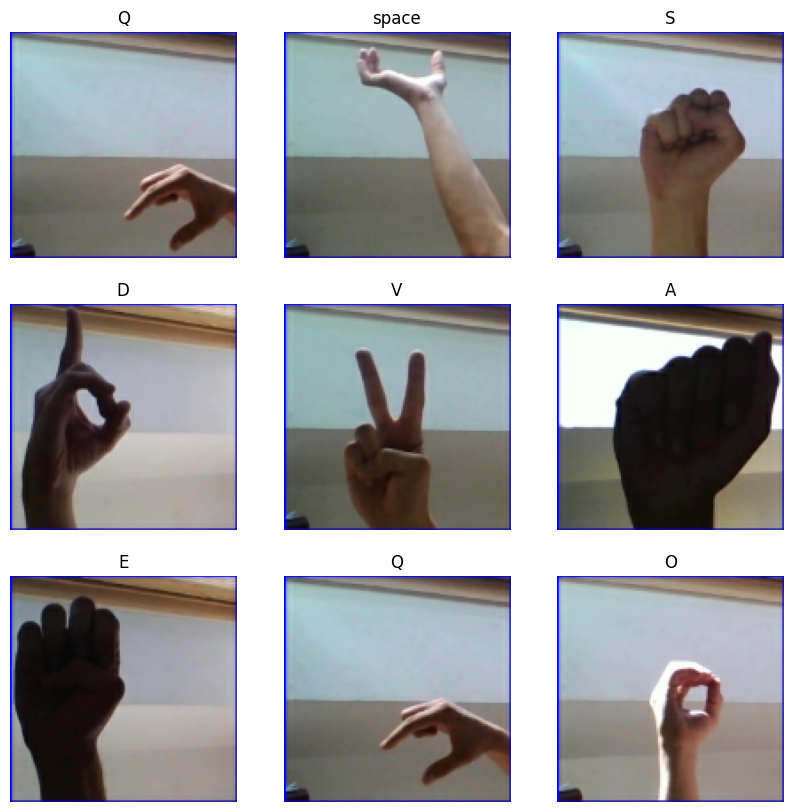

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

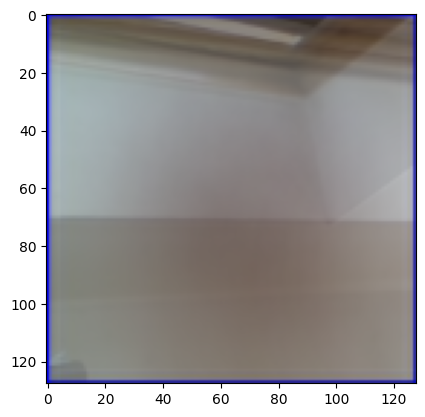

In [8]:
running_mean = tf.zeros(IMG_DIM)
img_num = 0
for imgs, lables in train_ds.take(100):
    
    running_mean = (img_num*running_mean+imgs.shape[0]*(tf.math.reduce_mean(imgs,0)/255))/(imgs.shape[0] + img_num)
    img_num+=imgs.shape[0]

plt.imshow(running_mean.numpy())

In [9]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

## Baseline model

Simple linear regression

In [10]:
lr_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

#using rms optimizer 
lr_model.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
history = lr_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
1632/1632 [==============================] - 6s 4ms/step - loss: 2.8622 - accuracy: 0.4377 - val_loss: 3.5590 - val_accuracy: 0.3726
Epoch 2/50
1632/1632 [==============================] - 6s 4ms/step - loss: 2.7967 - accuracy: 0.4493 - val_loss: 3.2646 - val_accuracy: 0.3852
Epoch 3/50
1632/1632 [==============================] - 6s 4ms/step - loss: 2.7324 - accuracy: 0.4587 - val_loss: 2.9928 - val_accuracy: 0.4094
Epoch 4/50
1632/1632 [==============================] - 6s 4ms/step - loss: 2.6810 - accuracy: 0.4640 - val_loss: 2.3429 - val_accuracy: 0.4708
Epoch 5/50
1632/1632 [==============================] - 6s 4ms/step - loss: 2.6253 - accuracy: 0.4729 - val_loss: 3.2852 - val_accuracy: 0.4110
Epoch 6/50
1632/1632 [==============================] - 6s 4ms/step - loss: 2.5672 - accuracy: 0.4797 - val_loss: 1.9147 - val_accuracy: 0.5282
Epoch 7/50
1632/1632 [==============================] - 6s 3ms/step - loss: 2.5283 - accuracy: 0.4869 - val_loss: 2.5748 - val_accuracy:

In [14]:
res = lr_model.evaluate(test_ds)
print("test loss, test acc:", res)
lr_model.summary()

544/544 [==============================] - 4s 7ms/step - loss: 1.6462 - accuracy: 0.6486
test loss, test acc: [1.646167278289795, 0.6486098170280457]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 56, 56, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 56, 56, 3)         0         
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 29)                272861    
                                                                 
Total params: 272,861
Trainable params: 272,861
Non-trainable params: 0
_________________________________________________________________


In [15]:
lr_model.save('linearModel.keras')

## Neural Network

In [16]:
model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
1632/1632 [==============================] - 9s 5ms/step - loss: 2.2625 - accuracy: 0.2897 - val_loss: 1.6794 - val_accuracy: 0.4232
Epoch 2/50
1632/1632 [==============================] - 8s 5ms/step - loss: 1.2505 - accuracy: 0.5649 - val_loss: 1.1619 - val_accuracy: 0.5930
Epoch 3/50
1632/1632 [==============================] - 8s 5ms/step - loss: 0.9173 - accuracy: 0.6758 - val_loss: 0.9730 - val_accuracy: 0.6541
Epoch 4/50
1632/1632 [==============================] - 8s 5ms/step - loss: 0.7410 - accuracy: 0.7354 - val_loss: 0.6528 - val_accuracy: 0.7641
Epoch 5/50
1632/1632 [==============================] - 8s 5ms/step - loss: 0.6423 - accuracy: 0.7688 - val_loss: 0.7623 - val_accuracy: 0.7358
Epoch 6/50
1632/1632 [==============================] - 8s 5ms/step - loss: 0.5912 - accuracy: 0.7891 - val_loss: 0.6510 - val_accuracy: 0.7647
Epoch 7/50
1632/1632 [==============================] - 8s 5ms/step - loss: 0.5062 - accuracy: 0.8186 - val_loss: 0.5298 - val_accuracy:

In [18]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)
model.save('neural.keras')

544/544 [==============================] - 4s 7ms/step - loss: 0.2754 - accuracy: 0.9257
test loss, test acc: [0.27543580532073975, 0.925666332244873]


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 56, 56, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 56, 56, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 9408)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               2408704   
                                                                 
 normalization (Normalizatio  (None, 256)              513       
 n)                                                              
                                                                 
 activation (Activation)     (None, 256)               0         
                                                      

## Preprocessing


In [20]:
from dataTransformer import *


transformer = TransformLayer(layers=create_transformation_layer())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


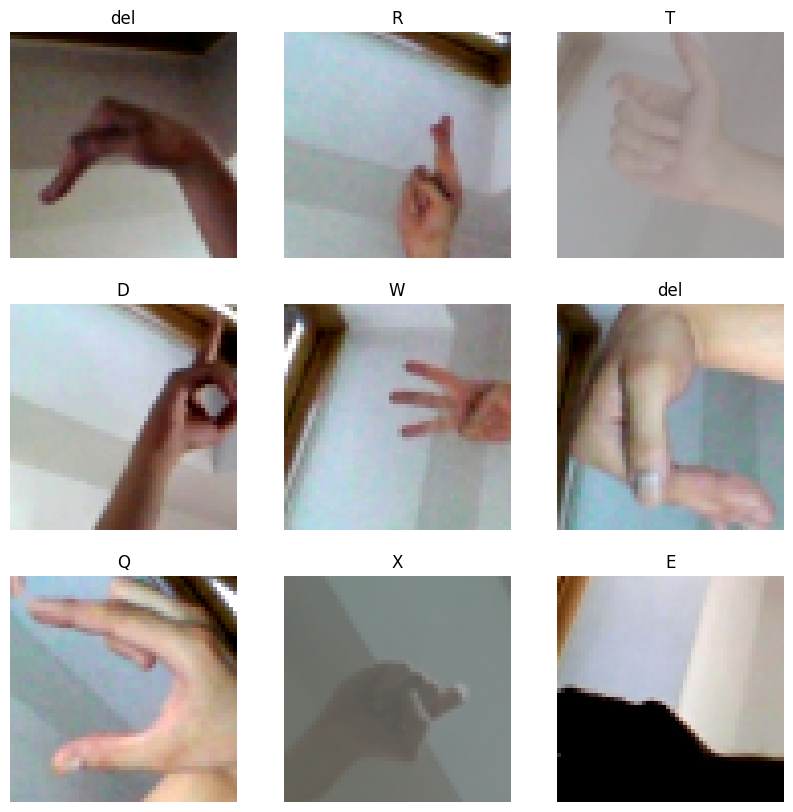

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow( transformer(images[i],training=True).numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

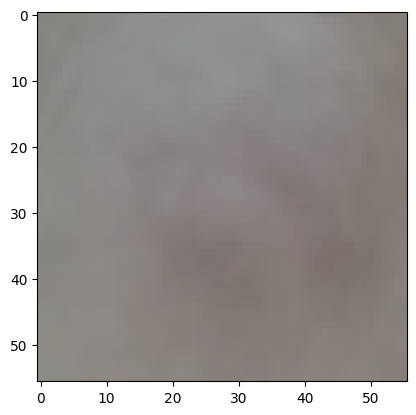

In [22]:
running_mean = tf.zeros(INPUT_SHAPE)
img_num = 0
for imgs, lables in train_ds.take(5):
    newImgs = transformer(imgs,training=True)
    running_mean = (img_num*running_mean+newImgs.shape[0]*(tf.math.reduce_mean(newImgs,0)))/(newImgs.shape[0] + img_num)
    img_num+=newImgs.shape[0]

plt.imshow(running_mean.numpy())

## Neural network - Again

same model, 2.5m parameters

In [23]:
model = tf.keras.Sequential([
  *create_transformation_layer(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
1632/1632 [==============================] - 14s 8ms/step - loss: 3.3637 - accuracy: 0.0407 - val_loss: 3.3148 - val_accuracy: 0.0538
Epoch 2/15
1632/1632 [==============================] - 13s 8ms/step - loss: 3.3132 - accuracy: 0.0516 - val_loss: 3.2689 - val_accuracy: 0.0585
Epoch 3/15
1632/1632 [==============================] - 14s 8ms/step - loss: 3.2927 - accuracy: 0.0572 - val_loss: 3.2418 - val_accuracy: 0.0628
Epoch 4/15
1632/1632 [==============================] - 14s 8ms/step - loss: 3.2615 - accuracy: 0.0620 - val_loss: 3.1852 - val_accuracy: 0.0814
Epoch 5/15
1632/1632 [==============================] - 14s 8ms/step - loss: 3.2306 - accuracy: 0.0720 - val_loss: 3.3475 - val_accuracy: 0.0504
Epoch 6/15
1632/1632 [==============================] - 13s 8ms/step - loss: 3.2177 - accuracy: 0.0736 - val_loss: 3.1390 - val_accuracy: 0.0840
Epoch 7/15
1632/1632 [==============================] - 13s 8ms/step - loss: 3.2057 - accuracy: 0.0762 - val_loss: 3.1360 - val_ac

In [25]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)
model.save('neural2.keras')

544/544 [==============================] - 5s 9ms/step - loss: 3.1437 - accuracy: 0.0831
test loss, test acc: [3.143745183944702, 0.08306525647640228]


## CNN - 12-layer Resnet

In [26]:
from dataTransformer import *

model = tf.keras.Sequential([
  *create_transformation_layer(),
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=1),#56x56
  ResnetBlock(5,filt=64,filt_in=32,num=2,stride=2),#28x28
  ResnetBlock(5,filt=64,num=2),

  ResnetBlock(3,filt=128,filt_in=64,num=2,stride=2),#14x14
  ResnetBlock(3,filt=128,filt_in=128,num=2),

  ResnetBlock(3,filt=256,filt_in=128,num=2,stride=2),#7x7
  ResnetBlock(3,filt=256,filt_in=256,num=2),

  tf.keras.layers.AveragePooling2D(7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.build([None,*IMG_DIM])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 center_crop_2 (CenterCrop)  (None, 118, 118, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 118, 118, 3)      0         
 tation)                                                         
                                                                 
 random_crop_2 (RandomCrop)  (None, 96, 96, 3)         0         
                                                                 
 resizing_4 (Resizing)       (None, 56, 56, 3)         0         
                                                                 
 random_contrast_2 (RandomCo  (None, 56, 56, 3)        0         
 ntrast)                                              

this model has only 3.4M params but preforms much better

In [27]:
from datetime import datetime

In [28]:
# Create a TensorBoard callback
#logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
#                                                 histogram_freq = 1,profile_batch = '500,520')


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,callbacks = [])


Epoch 1/15
1632/1632 [==============================] - 41s 22ms/step - loss: 1.8923 - accuracy: 0.4290 - val_loss: 1.4109 - val_accuracy: 0.5494
Epoch 2/15
1632/1632 [==============================] - 46s 28ms/step - loss: 0.6568 - accuracy: 0.7865 - val_loss: 2.0612 - val_accuracy: 0.4964
Epoch 3/15
1632/1632 [==============================] - 42s 26ms/step - loss: 0.4014 - accuracy: 0.8689 - val_loss: 0.3967 - val_accuracy: 0.8688
Epoch 4/15
1632/1632 [==============================] - 46s 28ms/step - loss: 0.2881 - accuracy: 0.9045 - val_loss: 0.3379 - val_accuracy: 0.8855
Epoch 5/15
1632/1632 [==============================] - 42s 26ms/step - loss: 0.2362 - accuracy: 0.9222 - val_loss: 2.6447 - val_accuracy: 0.5797
Epoch 6/15
1632/1632 [==============================] - 62s 38ms/step - loss: 0.1915 - accuracy: 0.9367 - val_loss: 0.1461 - val_accuracy: 0.9507
Epoch 7/15
1632/1632 [==============================] - 73s 45ms/step - loss: 0.1723 - accuracy: 0.9413 - val_loss: 0.7383 -

In [29]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)
model.save_weights('cnn.keras')

544/544 [==============================] - 6s 12ms/step - loss: 0.2093 - accuracy: 0.9400
test loss, test acc: [0.20927093923091888, 0.9400275945663452]


In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 center_crop_2 (CenterCrop)  (None, 118, 118, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 118, 118, 3)      0         
 tation)                                                         
                                                                 
 random_crop_2 (RandomCrop)  (None, 96, 96, 3)         0         
                                                                 
 resizing_4 (Resizing)       (None, 56, 56, 3)         0         
                                                                 
 random_contrast_2 (RandomCo  (None, 56, 56, 3)        0         
 ntrast)                                              

## Comparison